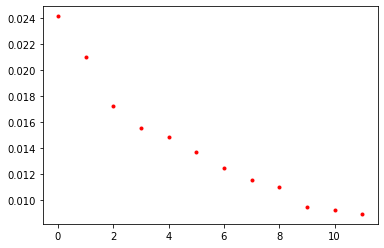

In [59]:
import sys
sys.path.append("..")
import os

import lauetools.LaueTools.IOimagefile as IOimage

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy import fft

from sklearn import metrics
from sklearn import cluster
from sklearn.feature_extraction.image import grid_to_graph

sx,sy=25,25

def reduce(im, sx, sy, lp, hp):
    SX, SY = im.shape
    im_ = im.reshape(sx, SX // sx, sy,SY // sy).mean(-1).mean(1)
    #ss=cv2.dct(im_)
    ss=fft.dctn(im_)
    ss[:lp, :] = 0.
    ss[:, :lp] = 0.
    ss[hp:, :] = 0.
    ss[:, hp:] = 0.
    #return cv2.idct(ss), ss[lp: hp, lp: hp].ravel()
    return fft.idctn(ss), ss[lp: hp, lp: hp].ravel()

features=np.load('features4096.npy')#[:sx,:sy,:]
features=features.reshape((64*146,4096))

from sklearn.decomposition import PCA

n_pca=12
pca = PCA(n_components=n_pca, svd_solver='randomized')#,whiten=True)

pca_features=pca.fit_transform(features)#components_

plt.plot(np.arange(n_pca), pca.explained_variance_ratio_,'r.')
pca_features=pca_features.reshape((64,146,n_pca))[:sx,:sy,:].reshape((sx*sy,n_pca))

C:\Users\fengg\anaconda3\lib\site-packages\scikit_learn-0.24.dev0-py3.8-win-amd64.egg\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


42


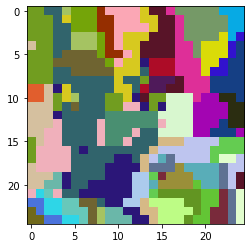

In [60]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(preference=-50).fit(pca_features)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)
colors=np.random.uniform(size=(n_clusters_,3))
print(n_clusters_)
labels=labels.reshape((sx,sy))
im=np.zeros(tuple(list(labels.shape)+[3]))
for i in range(sx):
    for j in range(sy):
        im[i,j]=colors[labels[i,j]]
plt.imshow(im)
plt.savefig('comparison_ap%i.png'%n_clusters_,format='png',bbox_inches ='tight')

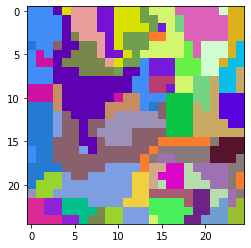

In [61]:
from sklearn.cluster import KMeans

colors=np.random.uniform(size=(n_clusters_,3))

labels = KMeans(n_clusters=n_clusters_, init='k-means++').fit_predict(pca_features)


labels=labels.reshape((sx,sy))
im=np.zeros(tuple(list(labels.shape)+[3]))
for i in range(sx):
    for j in range(sy):
        im[i,j]=colors[labels[i,j]]
plt.imshow(im)
plt.savefig('comparison_kmean%i.png'%n_clusters_,format='png',bbox_inches ='tight')

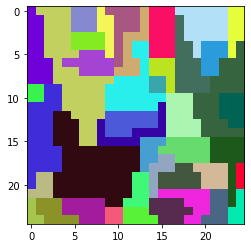

In [62]:
from sklearn.feature_extraction.image import grid_to_graph

connectivity = grid_to_graph(n_x=sx, n_y=sy)

from sklearn.cluster import AgglomerativeClustering
colors=np.random.uniform(size=(n_clusters_,3))


ward = cluster.AgglomerativeClustering(n_clusters=n_clusters_, connectivity=connectivity, linkage='ward').fit(pca_features)
labels = ward.labels_

labels=labels.reshape((sx,sy))
im=np.zeros(tuple(list(labels.shape)+[3]))
for i in range(sx):
    for j in range(sy):
        im[i,j]=colors[labels[i,j]]
plt.imshow(im)
plt.savefig('comparison_ac%i.png'%n_clusters_,format='png',bbox_inches ='tight')